In [1]:
!pip install pulp
from pulp import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [2]:
payments = [11000,12000,14000,15000,16000,
            18000,20000,21000,22000,24000,
            25000,30000,31000,31000,31000]

yields = [[0,60,60,60,60,1060,0,0,0,0,0,0,0,0,0],
          [0,65,65,65,65,65,65,65,65,65,65,1060,0,0,0],
          [0,75,75,75,75,75,75,75,75,75,75,75,75,75,1075]
         ]

costs = [980,970,1050]

bonds = range(len(costs))
years = range(len(payments))

In [3]:
# Problem
prob = LpProblem("Pension_Fund", LpMaximize)

# Variables
## number of bond i bought 
x = LpVariable.dicts("Bond", bonds, 0)
## cash available at the end of year j
y = LpVariable.dicts("Cash", years, 0)

# Objective function
prob += lpSum([yields[i][k]*x[i] for i in bonds for k in years]+
              [-costs[i]*x[i] for i in bonds] +
              [-payments[k] for k in years]) + 250000

# Constraints 
for j in years:
    prob += lpSum([yields[i][k]*x[i] for i in bonds for k in range(j+1)]+
                  [-costs[i]*x[i] for i in bonds] +
                  [-payments[k] for k in range(j+1)]) + 250000 == y[j]
    
for j in years:
    prob += y[j] >= 0

In [4]:
print(prob)

Pension_Fund:
MAXIMIZE
320*Bond_0 + 740*Bond_1 + 1000*Bond_2 + -71000
SUBJECT TO
_C1: - 980 Bond_0 - 970 Bond_1 - 1050 Bond_2 - Cash_0 = -239000

_C2: - 920 Bond_0 - 905 Bond_1 - 975 Bond_2 - Cash_1 = -227000

_C3: - 860 Bond_0 - 840 Bond_1 - 900 Bond_2 - Cash_2 = -213000

_C4: - 800 Bond_0 - 775 Bond_1 - 825 Bond_2 - Cash_3 = -198000

_C5: - 740 Bond_0 - 710 Bond_1 - 750 Bond_2 - Cash_4 = -182000

_C6: 320 Bond_0 - 645 Bond_1 - 675 Bond_2 - Cash_5 = -164000

_C7: 320 Bond_0 - 580 Bond_1 - 600 Bond_2 - Cash_6 = -144000

_C8: 320 Bond_0 - 515 Bond_1 - 525 Bond_2 - Cash_7 = -123000

_C9: 320 Bond_0 - 450 Bond_1 - 450 Bond_2 - Cash_8 = -101000

_C10: 320 Bond_0 - 385 Bond_1 - 375 Bond_2 - Cash_9 = -77000

_C11: 320 Bond_0 - 320 Bond_1 - 300 Bond_2 - Cash_10 = -52000

_C12: 320 Bond_0 + 740 Bond_1 - 225 Bond_2 - Cash_11 = -22000

_C13: 320 Bond_0 + 740 Bond_1 - 150 Bond_2 - Cash_12 = 9000

_C14: 320 Bond_0 + 740 Bond_1 - 75 Bond_2 - Cash_13 = 40000

_C15: 320 Bond_0 + 740 Bond_1 + 1000 Bon

In [5]:
# Optimize
prob.solve()

# Print the status of the solved LP
print("Status = %s" % LpStatus[prob.status])

Status = Optimal


In [6]:
# Print the value of the variables at the optimum
for b in bonds:
    print("%s = %f" % (x[b].name, x[b].varValue))

# Print the value of the objective
print("Objective = %f" % value(prob.objective))

Bond_0 = 31.109215
Bond_1 = 55.529010
Bond_2 = 147.285550
Objective = 127331.966200


In [7]:
data_fixed = pd.DataFrame([y[j].varValue for j in years] , index = years, columns = ['fixed'])

sigma = 500
nb_scenarios = 100
payments_random = [np.random.normal(payments[j], sigma, nb_scenarios) for j in years]
data_scenarios = pd.DataFrame([sum([yields[i][k]*x[i].varValue for i in bonds for k in range(j+1)]) + 
                               sum([-costs[i]*x[i].varValue for i in bonds]) +
                               sum([-payments_random[k] for k in range(j+1)]) + 250000 for j in years],
                              index = years
                             )

data = pd.concat([data_fixed, data_scenarios], axis=1).reset_index().melt(id_vars=['index']).rename(columns={'index':'year', 'variable':'scenario'})
data['kind'] = np.where(data['scenario']=='fixed', 'fixed', 'random')

In [8]:
data.sort_values('value')

,year,scenario,value,kind
208,13,12,-6133.707808,random
43,13,1,-5706.613475,random
205,10,12,-4491.390204,random
763,13,49,-3950.750115,random
823,13,53,-3855.806399,random
...,...,...,...,...
374,14,23,130857.673291,random
1499,14,98,130921.768207,random
1244,14,81,131047.209651,random
689,14,44,131619.467703,random


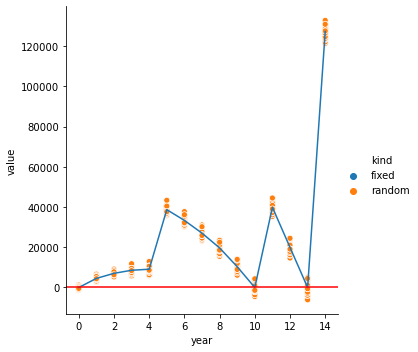

In [9]:
sns.relplot(x='year', y='value', data=data, hue='kind')
plt.plot(years, data_fixed)
plt.axhline(0, color='red')
plt.show()

The blue line shows year by year cash profile. It's clear to see that with some uncertainty in the data, the line could easily dive below $0$. Let's assume that $\beta_j$ introduced above are expected values of random payments $\beta_{j*}$. We will further assume that $\beta_{j*}$ is normally distributed with $\sigma = 500$. When 100 different payment profiles were simulated based on the normal distribution we can clearly see that it's actually possible for the cash to dive below $0$ which shouldn't be allowed based on the constraint of the problem.

## Chance Constraints 
To incorporate uncertainty into this question, we will look at chance constraints.

In [10]:
def pension_problem(payments, yields, costs, payments_random, sigma, prob=0.95, print_problem=False, output=True):
    
    bonds = range(len(costs))
    years = range(len(payments))
    
    # Problem
    p = LpProblem("Pension_Fund", LpMaximize)

    # Variables
    ## number of bond i bought 
    x = LpVariable.dicts("Bond", bonds, 0)
    ## cash available at the end of year j
    y = LpVariable.dicts("Cash", years, 0)

    # Objective function
    p += lpSum([yields[i][k]*x[i] for i in bonds for k in years]+
                  [-costs[i]*x[i] for i in bonds] +
                  [-payments[k] for k in years]) + 250000

    # Constraints 
    for j in years:
        p += lpSum([yields[i][k]*x[i] for i in bonds for k in range(j+1)]+
                      [-costs[i]*x[i] for i in bonds] +
                      [-payments[k] for k in range(j+1)]) + 250000 == y[j]

    for j in years:
        p += y[j] >= sigma*norm.ppf(prob)
    
    if print_problem:
        print(p)
    
    # Optimize
    p.solve()
    
    
    # Print the status of the solved LP, if not optimal
    if p.status !=1:
        print("Status = %s" % LpStatus[p.status])
    obj = value(p.objective)
    
    if output:   
        # Print the value of the variables at the optimum
        for b in bonds:
            print("%s = %f" % (x[b].name, x[b].varValue))
        # Print the value of the objective
        print("Objective = %f" % obj)
    
    res = pd.DataFrame([sum([yields[i][k]*x[i].varValue for i in bonds for k in range(j+1)]) + 
                        sum([-costs[i]*x[i].varValue for i in bonds]) +
                        sum([-payments_random[k] for k in range(j+1)]) + 250000 for j in years],
                       index = years
                      )
    
    return(res, obj)

In [12]:
data_scenarios, obj = pension_problem(payments, yields, costs, payments_random, sigma, prob=0.95, print_problem=True)

Pension_Fund:
MAXIMIZE
320*Bond_0 + 740*Bond_1 + 1000*Bond_2 + -71000
SUBJECT TO
_C1: - 980 Bond_0 - 970 Bond_1 - 1050 Bond_2 - Cash_0 = -239000

_C2: - 920 Bond_0 - 905 Bond_1 - 975 Bond_2 - Cash_1 = -227000

_C3: - 860 Bond_0 - 840 Bond_1 - 900 Bond_2 - Cash_2 = -213000

_C4: - 800 Bond_0 - 775 Bond_1 - 825 Bond_2 - Cash_3 = -198000

_C5: - 740 Bond_0 - 710 Bond_1 - 750 Bond_2 - Cash_4 = -182000

_C6: 320 Bond_0 - 645 Bond_1 - 675 Bond_2 - Cash_5 = -164000

_C7: 320 Bond_0 - 580 Bond_1 - 600 Bond_2 - Cash_6 = -144000

_C8: 320 Bond_0 - 515 Bond_1 - 525 Bond_2 - Cash_7 = -123000

_C9: 320 Bond_0 - 450 Bond_1 - 450 Bond_2 - Cash_8 = -101000

_C10: 320 Bond_0 - 385 Bond_1 - 375 Bond_2 - Cash_9 = -77000

_C11: 320 Bond_0 - 320 Bond_1 - 300 Bond_2 - Cash_10 = -52000

_C12: 320 Bond_0 + 740 Bond_1 - 225 Bond_2 - Cash_11 = -22000

_C13: 320 Bond_0 + 740 Bond_1 - 150 Bond_2 - Cash_12 = 9000

_C14: 320 Bond_0 + 740 Bond_1 - 75 Bond_2 - Cash_13 = 40000

_C15: 320 Bond_0 + 740 Bond_1 + 1000 Bon

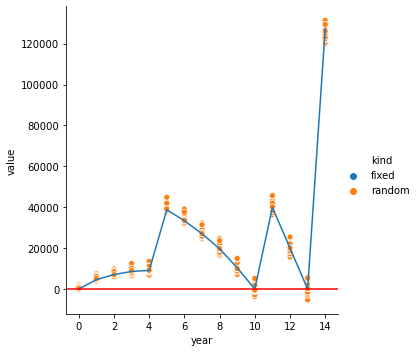

In [13]:
data = pd.concat([data_fixed, data_scenarios], axis=1).reset_index().melt(id_vars=['index']).rename(columns={'index':'year', 'variable':'scenario'})
data['kind'] = np.where(data['scenario']=='fixed', 'fixed', 'random')

sns.relplot(x='year', y='value', data=data, hue='kind')
plt.plot(years, data_fixed)
plt.axhline(0, color='red')
plt.show()

Trade-off between confidence level of always having a cash profile above $\$0$ and the final cash left in the company at the end of the 15 years.

In [14]:
cash_profil = {}
for prob in range(60,100,1):
    data_scenarios, obj = pension_problem(payments, yields, costs, payments_random, sigma, prob=prob/100, output=False)
    cash_profil[prob] = obj

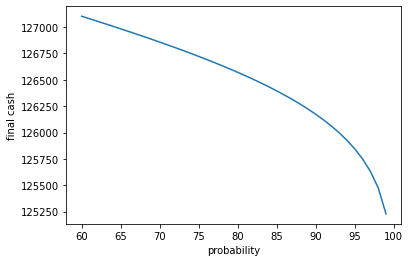

In [15]:
plt.plot(list(cash_profil.keys()), list(cash_profil.values()))
plt.xlabel('probability')
plt.ylabel('final cash')
plt.show()